# Classification des maladies foliaires de la tomate en utilisant les CNN (Version amélioré par DRIOUA Imed)

### Import all the Dependencies

In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras import layers, Sequential, models, preprocessing
import pathlib

### Définition des constantes et importation de données

In [62]:
taille_batch = 32
taille_image = 256
chann=3
epochs=50


In [63]:
images_data = tf.keras.preprocessing.image_dataset_from_directory(
    "tomate",
    seed=18,
    shuffle=True,
    image_size=(taille_image,taille_image),
    batch_size=taille_batch
)
class_names = images_data.class_names

Found 4500 files belonging to 3 classes.


### Images des différentes classes

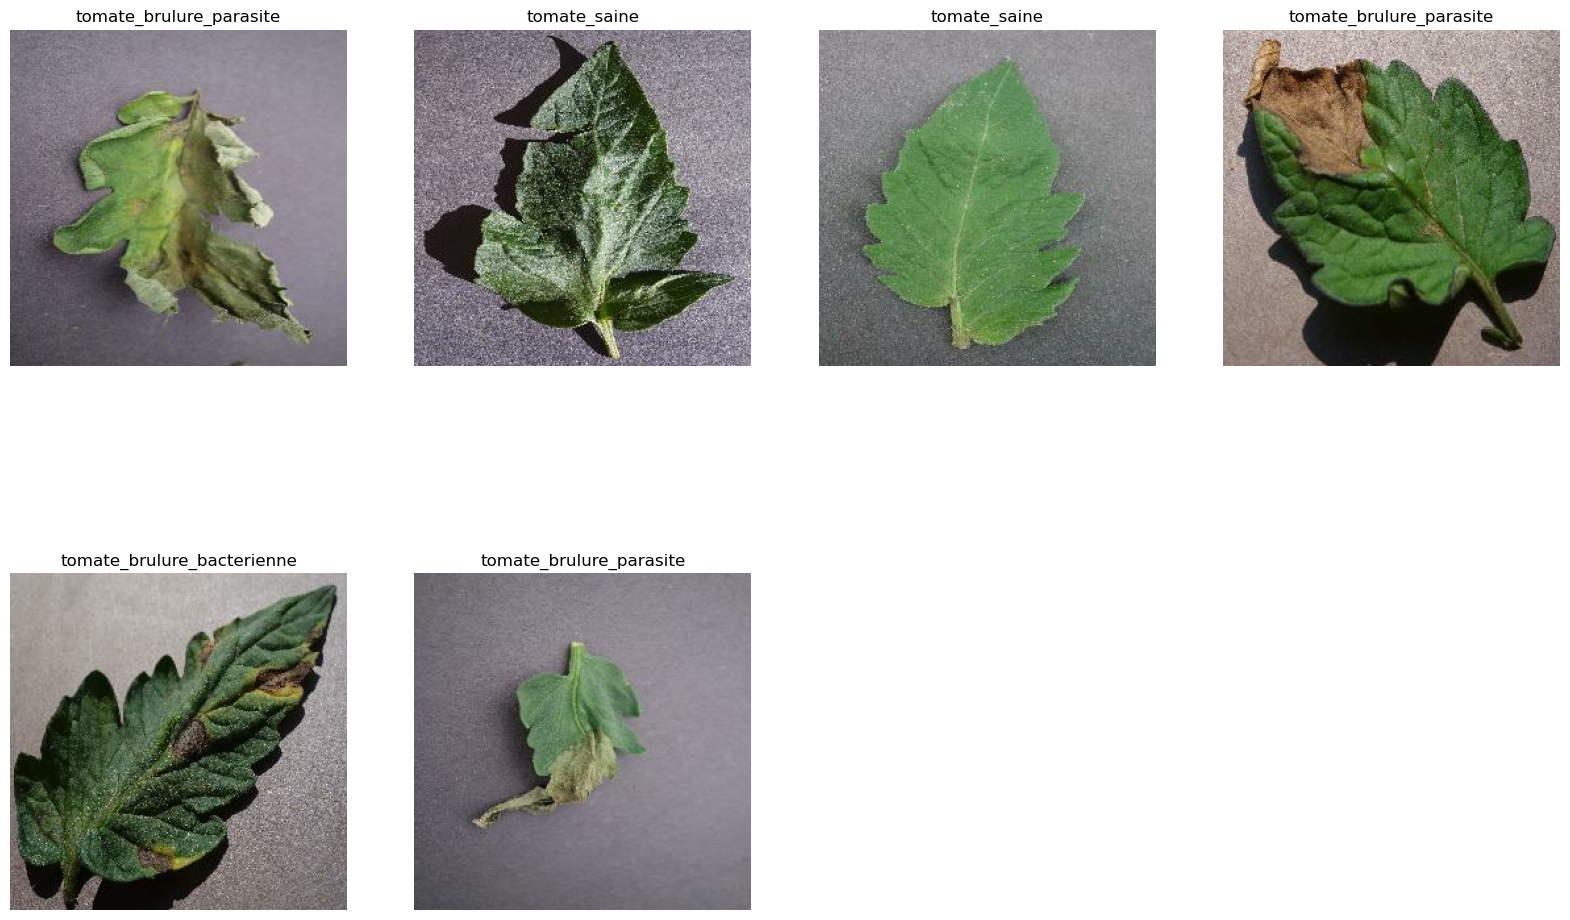

In [64]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in images_data.take(1):
    for i in range(6):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(images_data.class_names[labels_batch[i]])
        plt.axis("off")

## Division de l'ensemble de données

In [65]:
size = len(images_data)
train_p = 0.8 
test_s  = 0.1
validation_p = 0.1
images_data = images_data.shuffle(10000, seed=12)   
taille_train = int(train_p * size)
taille_validation = int(validation_p * size)
train_data = images_data.take(taille_train)    
validation_data = images_data.skip(taille_train).take(taille_validation)
test_data = images_data.skip(taille_train).skip(taille_validation)


### Normalisation et redimensionnement

1 - La première couche de notre modèle sera une couche de redimensionnement pour nos images. On a déjà redimensionné les images d'entraînement avant mais on doit rajouter cette couche pour que notre modèle soit capable de fonctionner après l'entraînement même avec les images qui sont pas en (256, 256).

2 - La deuxième couche est une couche de normalisation, pour normaliser les valeurs de pixels de nos images, cela rentre dans le cadre de l'amélioration des performances du modèle.


In [68]:
couches_normalisation_redimenssionement = keras.Sequential([
  layers.Resizing(taille_image, taille_image),
  layers.Rescaling(1./255),
])

### Augmentation de données
Afin de booster les performances de notre modèle et le rendre le plus général possible, on peut faire une augmentation de données, cela en faisant des déformations sur nos images ( rotation verticale et horizontale ).
Pour cela, on ajoute deux couches à notre modèle comme suit : 


In [69]:
couches_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [70]:
# On préfère de faire l'augmenttation séparement (On aurait pu l'inclure dans le modèle)
train_data_augmented = train_data.map(
    lambda ent, srt: (couches_augmentation(ent, training=True),srt)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Le modèle


In [71]:
classifieur_images = models.Sequential([
    couches_normalisation_redimenssionement,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape= (taille_batch, taille_image, taille_image, chann)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

classifieur_images.build(input_shape= (taille_batch, taille_image, taille_image, chann))
classifieur_images.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (32, 60, 60, 64)        

In [72]:
classifieur_images.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [73]:
# Ici on utilise un callback pour arrêter l'entraînement quand les valeurs ne s'améliorent plus après 4 epochs consécutifs
early_stopping = EarlyStopping(monitor="val_loss", patience=4)


In [74]:
import time

start_time = time.time()
history = classifieur_images.fit(
    train_data_augmented,
    batch_size=taille_batch,
    validation_data=validation_data,
    verbose=1,
    epochs=epochs,
    callbacks=[early_stopping]
)
end_time = time.time()
total_time = end_time - start_time
print("Le temps d'entrainement : ", total_time)

Epoch 1/20
112/112 [==============================] - 105s 920ms/step - loss: 0.8866 - accuracy: 0.5538 - val_loss: 0.6454 - val_accuracy: 0.7225
Epoch 2/20
112/112 [==============================] - 107s 942ms/step - loss: 0.4423 - accuracy: 0.8158 - val_loss: 0.4486 - val_accuracy: 0.8281
Epoch 3/20
112/112 [==============================] - 107s 944ms/step - loss: 0.3682 - accuracy: 0.8536 - val_loss: 0.4118 - val_accuracy: 0.8504
Epoch 4/20
112/112 [==============================] - 106s 933ms/step - loss: 0.3265 - accuracy: 0.8681 - val_loss: 0.2205 - val_accuracy: 0.9085
Epoch 5/20
112/112 [==============================] - 111s 982ms/step - loss: 0.3733 - accuracy: 0.8527 - val_loss: 0.3515 - val_accuracy: 0.8460
Epoch 6/20
112/112 [==============================] - 106s 936ms/step - loss: 0.3217 - accuracy: 0.8648 - val_loss: 0.4281 - val_accuracy: 0.8527
Epoch 7/20
112/112 [==============================] - 108s 950ms/step - loss: 0.2801 - accuracy: 0.8849 - val_loss: 0.3744 -

In [ ]:
# Early stopping a permis de réduire le temps d'entrainement par 60%

### Plotting the Accuracy and Loss Curves

<AxesSubplot:title={'center':"Précision de l'entrainement et de la validation"}>

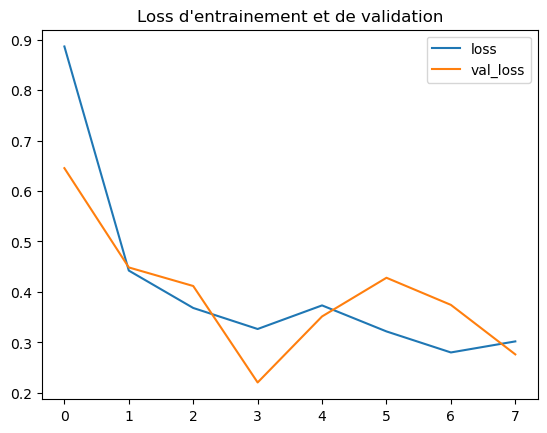

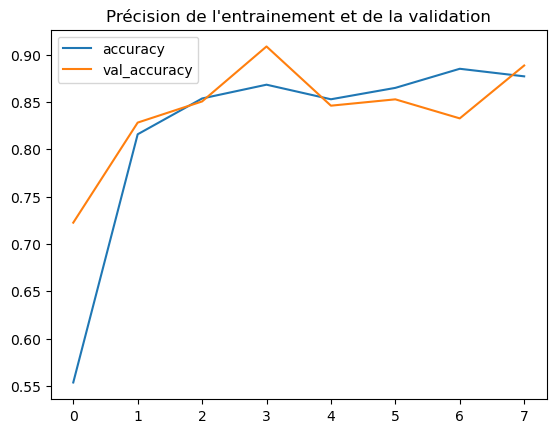

In [75]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss d'entrainement et de validation")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Précision de l'entrainement et de la validation")

### Exécution de la prédiction sur certaine images du test

Classe réel : tomate_brulure_parasite
Classe prédite: tomate_brulure_parasite


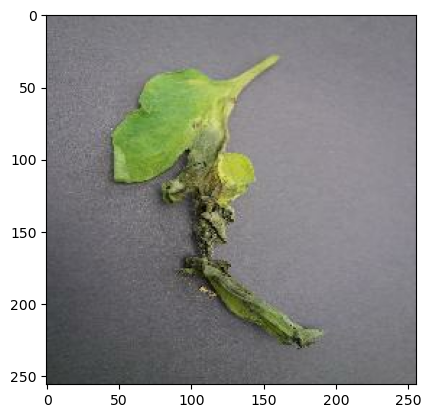

In [80]:
import numpy as np

for images_batch, labels_batch in test_data.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print("Classe réel :", class_names[first_label])
    
    batch_prediction = classifieur_images.predict(images_batch , verbose=0)
    print("Classe prédite:",class_names[np.argmax(batch_prediction[0])])
    
    

# Avec les nouvelles améliorations le modèle est devenu très performant (Tester plusieurs images pour voir l'effet)